In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import json
import pickle
from gcmap import GCMapper, Gradient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import PowerNorm, LogNorm, LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase
from tqdm import tqdm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern
import matplotlib.patches as mpatches

## load the IATA data
with open('data/IATA.json') as f:
    IATA = json.load(f)
    
## load the graph network
with open('data/graphnetwork.gpickle', 'rb') as f:
    G = pickle.load(f)

C:\Users\Andba\AppData\Local\Temp\ipykernel_21004\1227662919.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
## make G undirected
G_undirect = G.to_undirected(reciprocal=True)
source_lon, source_lat, destination_lon, destination_lat, nb_flights = [], [], [], [], []
edges = G_undirect.edges(data=True)
for u, v, data in edges:
    if u != v:
        source_lon.append(IATA[u]['longitude'])
        source_lat.append(IATA[u]['latitude'])
        destination_lon.append(IATA[v]['longitude'])
        destination_lat.append(IATA[v]['latitude'])
        nb_flights.append(data['weight'])
        
grad = Gradient(((0, 0, 0, 0), (0.5, 204, 0, 153), (1, 255, 204, 230)))
gcm = GCMapper(cols=grad, height=2000, width=4000)
gcm.set_data(source_lon, source_lat, destination_lon, destination_lat, nb_flights)
img = gcm.draw()
img.show()
img.save('images/flightmap.png')

In [1]:
## create a basemap
fig, ax = plt.subplots(figsize=(15, 10))
resolution = "c"
m = Basemap(lon_0=0, resolution=resolution)
m.drawmapboundary(fill_color='black')
# m.drawcoastlines(color="lightgrey", linewidth=0.3)

continent_to_color = {
    'Africa': (0.4, 0.7, 0.9), 
    'Asia': (0.6, 0.8, 0.6), 
    'Europe': (0.7, 0.6, 0.8), 
    'North America': (1.0, 0.7, 0.4), 
    'Oceania': (1.0, 1.0, 0.6), 
    'South America': (1.0, 0.6, 0.6)
    }

## plot the nodes
lons = [IATA[node]['longitude'] for node in G_undirect.nodes()]
lats = [IATA[node]['latitude'] for node in G_undirect.nodes()]
sizes = [0.2 * G_undirect.degree(node) for node in G_undirect.nodes()]
colors = [continent_to_color[IATA[node]['continent']] for node in G_undirect.nodes()]
x, y = m(lons, lats)
color = (204 / 255, 0 / 255, 153 / 255)
m.scatter(x, y, c=colors, s=sizes)
plt.legend(handles=[mpatches.Patch(color=continent_to_color[continent], label=continent) for continent in continent_to_color])
plt.savefig('images/flightmap_nodes.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

NameError: name 'plt' is not defined

In [8]:
import netwulf as nw
# nw.visualize(G)

(None, None)

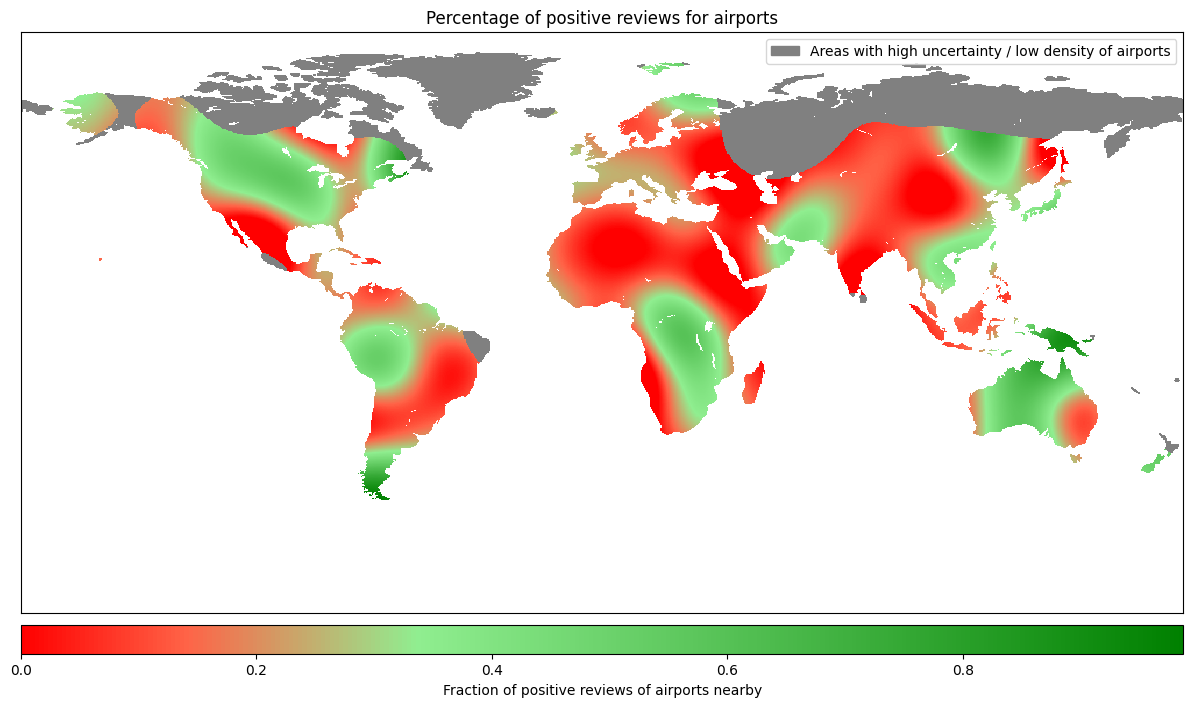

In [6]:
## make a grey cmap, that always returns grey
cmap_grey = LinearSegmentedColormap.from_list(
    "grey", 
    [(0, "grey"), (1, "grey")]
)

airports = pd.read_csv("data/airports_cleaned.csv", index_col=0)
airports = airports.dropna(subset=["average_recommendation"])
X = airports[["latitude", "longitude"]].to_numpy()
y = airports["average_recommendation"].to_numpy()

kernel = RBF(length_scale=15, length_scale_bounds="fixed")
model = GaussianProcessRegressor(kernel=kernel, alpha=0.1, normalize_y=True)
model.fit(X, y)

resolution = 1000
lats, lons = X[:, 0], X[:, 1]
min_lats, max_lats = -90, 90
min_lons, max_lons = -180, 180

lats = np.linspace(min_lats, max_lats, resolution)
lons = np.linspace(min_lons, max_lons, resolution)
lats, lons = np.meshgrid(lats, lons)
Xmesh = np.vstack([lats.ravel(), lons.ravel()]).T
ymesh, uncertainty = model.predict(Xmesh, return_std=True)
uncertainty = uncertainty.reshape((resolution, resolution))
ymesh = ymesh.reshape((resolution, resolution))
ymesh = np.clip(ymesh, 0, 1)

## get 25th and 75th percentile
percentilelow = np.percentile(ymesh.flatten(), 25)
percentilehigh = np.percentile(ymesh.flatten(), 80)

## make a colormap that is red for low values and green for high values of ymesh
cmap = LinearSegmentedColormap.from_list(
    "custom", 
    [(0, "red"), (percentilelow, "tomato"), (percentilehigh, "lightgreen"), (1, "green")]
) 

def is_water(lat, lon):
    return not m.is_land(lon, lat)

try: 
    ywater = np.load(f"data/ywater{resolution}.npy")
except:
    ywater = np.zeros_like(ymesh)
    for i in tqdm(range(ymesh.shape[0])):
        for j in range(ymesh.shape[1]):
            if is_water(lats[i, j], lons[i, j]):
                ywater[i, j] = 1
    np.save(f"data/ywater{resolution}.npy", ywater)
            
watermasked = np.ma.masked_where(ywater == 1, ymesh)
max_uncertainty = 0.15
uncertain_or_water_masked = np.ma.masked_where((uncertainty < max_uncertainty) | (ywater == 1), np.ones_like(ymesh))

fig, ax = plt.subplots(figsize=(15, 10))
m = Basemap(lon_0=0)
m.pcolormesh(lons, lats, watermasked, cmap=cmap, shading='auto')
m.colorbar(location="bottom", label="Fraction of positive reviews of airports nearby")
m.pcolor(lons, lats, uncertain_or_water_masked, cmap=cmap_grey)
## make a legend for the uncertainty
grey_patch = mpatches.Patch(color='grey', label='Areas with high uncertainty / low density of airports')
plt.legend(handles=[grey_patch])
plt.title("Percentage of positive reviews for airports")
plt.savefig('images/average_recommendation.png', dpi=300, bbox_inches='tight')